In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

%aimport CTR_Dominating_Stiffness
from CTR_Dominating_Stiffness import CTR_DomStiff
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### Define CTR Robot Object, Obtain and Plot Shape via Forward Kinematics

In [3]:
# Define Robot Constants
Lengths = [7,14,20] # --> [L3, L2, L1]
Curved_Lengths = [2,3,3] # --> [L3c, L2c, L1c] (less than or equal to) [L3, L2, L1]
Kappas = np.array([1/3,1/2,1]) # --> [k3, k2, k1]
# ^^^-------------- Kappas and Curved_Lengths are the parameters to be optimized by Tyler

# Create a CTR robot object
CTR_robot = CTR_DomStiff(Lengths, Curved_Lengths, Kappas)

In [4]:
# Specify kinematic inputs
kin_lengths = [6,2,2]
thetas = [0,0,0]

# Get (x,y) coordinate and direction vector of the tip
xy, norm_dir = CTR_robot.forward_kin(kin_lengths, thetas)
print(f"The tip is at (x,y) = ({xy[0]:.4f},{xy[1]:.4f})")
print(f"Normal direction of tip is ({norm_dir[0]:.4f},{norm_dir[1]:.4f})")

The tip is at (x,y) = (5.1125,3.1751)
Normal direction of tip is (-0.8653,-0.5013)


The merged robot shape is a numpy array of size (3000, 2),
each row is the (x,y) coordinate of one point along the robot arclength


Text(0.5, 1.0, 'Curve of CTR shape')

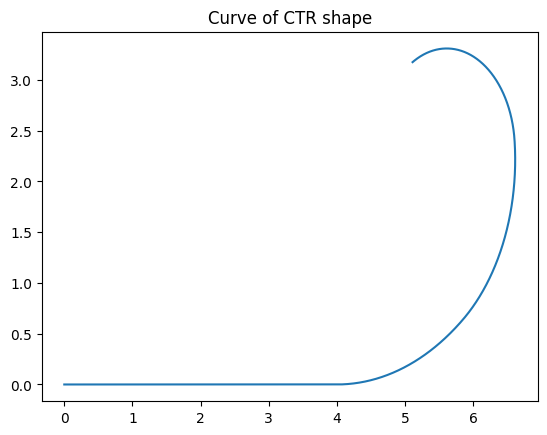

In [5]:
# Get the whole robot shape 
# USEFUL FOR SHAPE BOUNDARY
CTR_shape = CTR_robot.get_shape(kin_lengths, thetas)
print(f"The merged robot shape is a numpy array of size {CTR_shape.shape},"+ 
      "\neach row is the (x,y) coordinate of one point along the robot arclength")
plt.plot(CTR_shape[:,0],CTR_shape[:,1])
plt.title("Curve of CTR shape")

<AxesSubplot: >

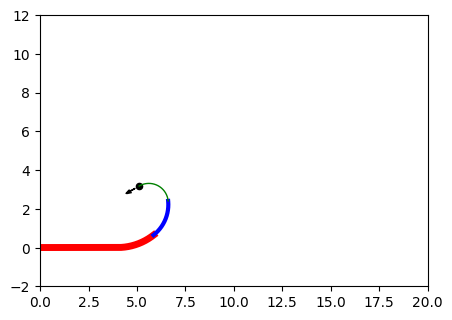

In [6]:
# OR, plot the robot shape using plot_forward with sections unmerged 
# (get_shape is wrapped inside plot_forward)
CTR_robot.plot_forward(kin_lengths, thetas)

### Obtain and Plot Inverse Kinematics Solutions

In [7]:
# Specify target (x,y) tip position and normal direction
target_xy= np.array([5,2])
target_dir= np.array([np.pi/4, np.pi/4])

# Obtain inverse kinematic results
inverse_results = CTR_robot.inverse_kin(target_xy, target_dir)

In [8]:
print(f"There are {len(inverse_results)} solutions, they are sorted such that "+
      "the best solution is at the start of the list. The best is:\n",inverse_results[0])
print(f"\nThe best solution has: \nKinematic lengths [l3, l2, l1] = {inverse_results[0][0]}"+
      f"\nThetas [theta3, theta2, theta1] = {inverse_results[0][1]}"+
      f"\nMinimized cost = {inverse_results[0][2]}")

There are 8 solutions, they are sorted such that the best solution is at the start of the list. The best is:
 ([4.2336703987073765, 1.1840404054226674, 0.4733004570168795], [0, 0, 3.141592653589793], 0.012259081983268716)

The best solution has: 
Kinematic lengths [l3, l2, l1] = [4.2336703987073765, 1.1840404054226674, 0.4733004570168795]
Thetas [theta3, theta2, theta1] = [0, 0, 3.141592653589793]
Minimized cost = 0.012259081983268716


Text(0.5, 1.0, 'The best solution')

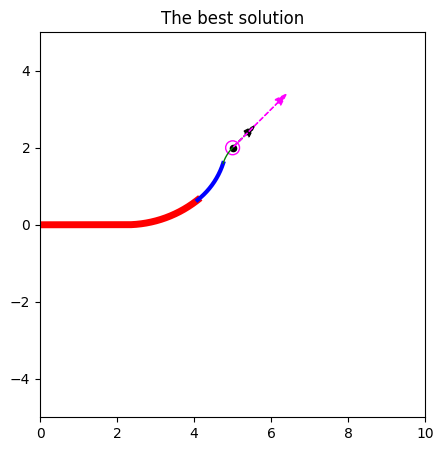

In [9]:
# Plot the best solution
ax = CTR_robot.plot_inverse(target_xy, target_dir, inverse_results, num_sol_to_plot=1)
ax.set_xlim(0,10)
ax.set_ylim(-5,5)
ax.set_title("The best solution")

Text(0.5, 1.0, 'Three best solutions')

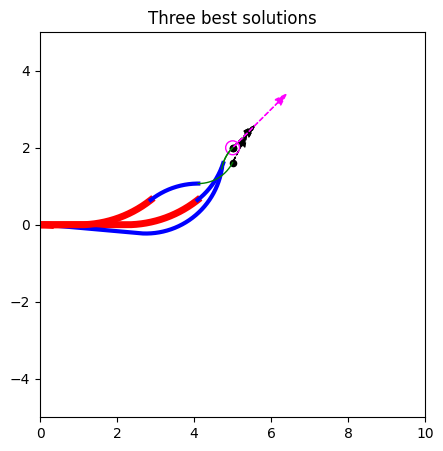

In [10]:
# Plot the three best solutions
ax = CTR_robot.plot_inverse(target_xy, target_dir, inverse_results, num_sol_to_plot=3)
ax.set_xlim(0,10)
ax.set_ylim(-5,5)
ax.set_title("Three best solutions")

In [11]:
# Using a custom cost for inverse kinematic (e.g., attenuate the weight of direction w.r.t. position)
def cost_inv_custom(target_xy, target_dir, tip_xy, normal_dir) -> float:
    return np.linalg.norm(tip_xy-target_xy)**2+ (0.1)*np.linalg.norm(normal_dir-target_dir)**2
inverse_results_new = CTR_robot.inverse_kin(target_xy, target_dir, cost_inv=cost_inv_custom)

(-5.0, 5.0)

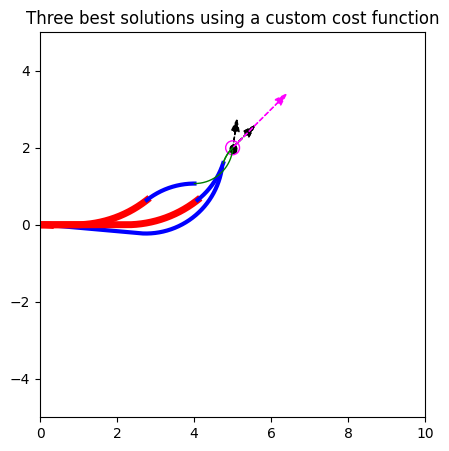

In [12]:
# Plot the new solutions
ax = CTR_robot.plot_inverse(target_xy, target_dir, inverse_results_new, num_sol_to_plot=3)
ax.set_title("Three best solutions using a custom cost function")
ax.set_xlim(0,10)
ax.set_ylim(-5,5)

Compare with the previous three best solutions, we see that the position is now more accurate at the cost of normal direction error

### Visualization with pipe profile

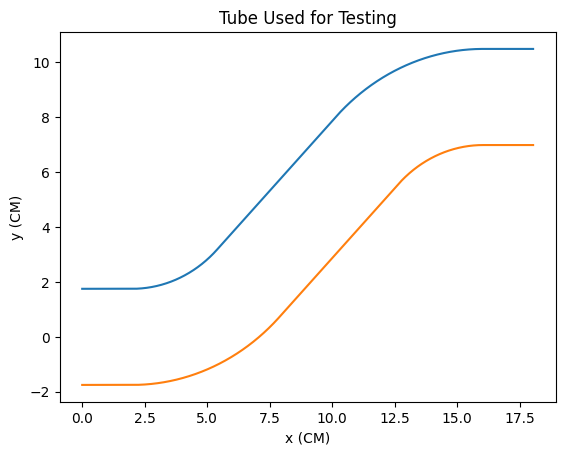

In [13]:
# Adding a pipe profile into the plots

# FROM TYLER
# define the pipe used for testing

tube_diameter = 35 # diameter of tube (mm)
tube_radius_of_curvature = 65 # radius of curvature of tube (mm)
tube_curve_length = 51.6 # length of curved section of tube in middle (mm)
middle_length = 68 # length of middle section of tube (mm)
end_lengths = 20 # length of straight sections at ends of tube (mm)

# define the tube used for testing using a numpy array
def create_tube(diameter, radius_of_curvature, curve_length, middle_length, end_lengths):
    theta = curve_length / radius_of_curvature
    x_final = 2*end_lengths + 2*radius_of_curvature*np.sin(theta) + middle_length*np.cos(theta)
    x = np.linspace(0, x_final, 1000)

    r_large = radius_of_curvature + diameter/2
    r_small = radius_of_curvature - diameter/2

    upper_x = [0]
    upper_x.append(end_lengths)
    upper_x.append(end_lengths + r_small*np.sin(theta))
    upper_x.append(end_lengths + r_small*np.sin(theta) + middle_length*np.cos(theta))
    upper_x.append(x_final - end_lengths)
    lower_x = [0]
    lower_x.append(end_lengths)
    lower_x.append(end_lengths + r_large*np.sin(theta))
    lower_x.append(end_lengths + r_large*np.sin(theta) + middle_length*np.cos(theta))
    lower_x.append(x_final - end_lengths)

    conditions = []
    upper = []
    lower = []
    
    upper.append(diameter/2)
    upper.append(lambda x: -np.sqrt(r_small**2 - (x - end_lengths)**2) + radius_of_curvature)
    upper.append(lambda x: np.tan(theta)*(x - upper_x[2]) + r_small*(1-np.cos(theta)) + diameter/2)
    upper.append(lambda x: np.sqrt(r_large**2 - (x - upper_x[4])**2) - radius_of_curvature + 2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta))
    upper.append(2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta) + diameter/2)
    lower.append(-diameter/2)
    lower.append(lambda x: -np.sqrt(r_large**2 - (x - end_lengths)**2) + radius_of_curvature)
    lower.append(lambda x: np.tan(theta)*(x - lower_x[2]) + r_large*(1-np.cos(theta)) - diameter/2)
    lower.append(lambda x: np.sqrt(r_small**2 - (x - lower_x[4])**2) - radius_of_curvature + 2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta))
    lower.append(2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta) - diameter/2)
    
    conditions_list = []
    for changes_x in [upper_x, lower_x]:
        conditions = []
        conditions.append((x <= changes_x[1]))
        conditions.append((x > changes_x[1]) & (x <= changes_x[2]))
        conditions.append((x > changes_x[2]) & (x <= changes_x[3]))
        conditions.append((x > changes_x[3]) & (x <= changes_x[4]))
        conditions.append((x > changes_x[4]))
        conditions_list.append(conditions)
    
    return x/10, np.piecewise(x, conditions_list[0], upper)/10, np.piecewise(x, conditions_list[1], lower)/10

# print(create_tube(x_vals, tube_diameter, tube_radius_of_curvature, tube_curve_length, middle_length, end_lengths))

# plot the tube used for testing
pipe = create_tube(tube_diameter, tube_radius_of_curvature, tube_curve_length, middle_length, end_lengths)
fig, ax = plt.subplots()
ax.plot(pipe[0], pipe[1])
ax.plot(pipe[0], pipe[2])
ax.set_title('Tube Used for Testing', wrap=True)
ax.set_xlabel('x (CM)')
ax.set_ylabel('y (CM)')
plt.show()

In [14]:
# Update the Pipe_Profile, note that this can also be done at the initialization stage
CTR_robot.Pipe_Profile = pipe

Text(0.5, 1.0, 'Three best solutions using a custom cost function')

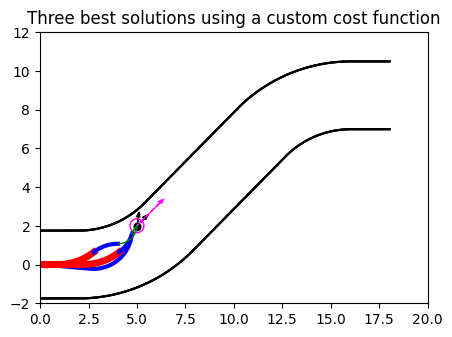

In [15]:
# Plot the three new solutions again, with pipe profile
ax = CTR_robot.plot_inverse(target_xy, target_dir, inverse_results_new, num_sol_to_plot=3)
ax.set_title("Three best solutions using a custom cost function")
# ax.set_xlim(0,10)
# ax.set_ylim(-5,5)

<AxesSubplot: >

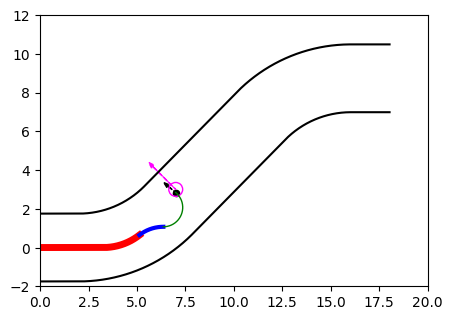

In [32]:
# Try to go to the top side of the pipe
target_xy_top = [7,3]
target_dir_top = [-np.pi/4,np.pi/4]
inverse_results_top = CTR_robot.inverse_kin(target_xy_top, target_dir_top)
CTR_robot.plot_inverse(target_xy_top, target_dir_top, inverse_results_top, num_sol_to_plot=1)

We see that this CTR of the given curvatures and curvature lengths could NOT reach the upper side of the pipe.

### CTR Optimization Pseudo-Code
Just bringing everything together...

First, set up the objective function

In [33]:
# Can also optimize the max extrusion lengths if desired, but set as constants for now
Lengths = [7,14,20]

# Specify pipe boundaries
Pipe_Profile = create_tube(tube_diameter, tube_radius_of_curvature, tube_curve_length, middle_length, end_lengths)

# Specify a list of (test (x,y)-coordinate, the normal direction)'s
test_targets = [([12.5,9],[-0.7,1])]

# Specify a function that takes in the robot shape and the pipe profile and return a cost value
def cost_boundary(robot_shape, pipe_profile) -> float:
    return 0

# OPTIONAL: specify a custom cost for position and direction error 
# (for inverse kinematic, and also the tubes optimization as a whole)
def cost_inv_custom(target_xy, target_dir, tip_xy, normal_dir) -> float:
    return np.linalg.norm(tip_xy-target_xy)**2+ np.linalg.norm(normal_dir-target_dir)**2

# Specify a function that combine the (position error & angular cost) with (boundary cost) to give a final cost
def combined_cost(cost_inv, cost_bound) -> float:
    return cost_inv + cost_bound

def objective_CTR(CurvedLengths_Kappa):
    Curved_Lengths = CurvedLengths_Kappa[0:3]
    Kappas = CurvedLengths_Kappa[3:6]
    Lengths = CurvedLengths_Kappa[6:9]
    CTR = CTR_DomStiff(Lengths, Curved_Lengths, Kappas, Pipe_Profile)
    final_cost = 0
    for (target_xy, target_dir) in test_targets:
        best_inverse_result = CTR.inverse_kin(target_xy, target_dir, cost_inv= cost_inv_custom)[0]
        (kin_lengths, thetas, cost_inv) = best_inverse_result
        robot_shape = CTR.get_shape(kin_lengths, thetas) # perhaps, this should be calculated simultaneously with cost_inv
        cost_bound = cost_boundary(robot_shape, CTR.Pipe_Profile)
        final_cost += combined_cost(cost_inv, cost_bound)
    # Take average across all points   
    final_cost = final_cost/len(test_targets)
    return final_cost

In [38]:
# Initial guess
initial_CurvedLengths_Kappa = [3,9,6,0.1,0.1,0.5,7,14,20] # --> [L3c, L2c, L1c, k3, k2, k1]

# Optimization bounds
opt_bounds = [(0, Lengths[0]), (0, Lengths[1]), (0, Lengths[2]), (0,2), (0,2), (0,2)]

# Obtain the optimized Curved Lengths and Curvatures
# opt_result = minimize(objective_CTR, initial_CurvedLengths_Kappa, method="Nelder-Mead", bounds=opt_bounds)
opt_result = minimize(objective_CTR, initial_CurvedLengths_Kappa, method="Nelder-Mead")


In [39]:
Curved_Lengths_opt = opt_result.x[0:3]
Kappas_opt = opt_result.x[3:6]
Lengths_opt = opt_result.x[6:9]
print(opt_result.x)

[ 2.87974698  8.64525377  6.09095807  0.10461264  0.09382842  0.48286981
  6.99615305 16.18773485 20.8537647 ]


<AxesSubplot: >

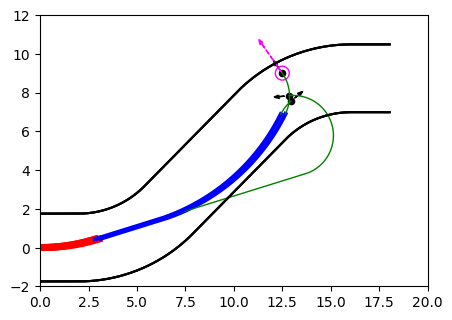

In [41]:
CTR_opt = CTR_DomStiff(Lengths_opt, Curved_Lengths_opt, Kappas_opt, Pipe_Profile)
target_xy_top = [12.5,9]
target_dir_top = [-0.7,1]
inverse_results_top_opt = CTR_opt.inverse_kin(target_xy_top, target_dir_top)
CTR_opt.plot_inverse(target_xy_top, target_dir_top, inverse_results_top_opt, num_sol_to_plot=3)

Lol, I tried XD. The problem might be the initialization and the fact that Nedler-Mead can get stuck in a local minimum (even though it is gradient free)...  